In [6]:
import json
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

# 1. Explore and evaluate different machine learning algorithms for Android malware detection

This suggests a comparative study of various ML algorithms to determine which are most effective for this specific application.

### Comparative Study of ML Algorithms

- Train various machine learning models like logistic regression, support vector machines, decision trees, random forests, gradient boosting machines, and neural networks on your dataset.
- Use cross-validation to evaluate their performance metrics (accuracy, precision, recall, F1 score, ROC-AUC, etc.).
- Perform statistical tests to determine if differences in performance are significant.



In [11]:
def load_X(dataset_path, reduced=False):
    print("Loading data (feature representation X, and feature names)...")
    # Load the reduced 10k features
    if reduced:
        with open('{}/X-10k.p'.format(dataset_path), 'rb') as f:
            X = pickle.load(f)
        with open('{}/f-10k.p'.format(dataset_path), 'rb') as f:
            feature_names = pickle.load(f)
    else:
        with open('{}/X.json'.format(dataset_path), 'r') as f:
            X = json.load(f)

        # Convert to numpy array and get feature names
        vec = DictVectorizer()
        X = vec.fit_transform(X).astype("float32")
        feature_names = vec.get_feature_names_out()

    return X, feature_names


def load_y(dataset_path):
    print('Loading labels...')
    with open('{}y.json'.format(dataset_path), 'rt') as f:
        y = json.load(f)
    y = np.asarray(y)
    return y


def load_metadata(dataset_path):
    print('Loading metadata...')
    with open('{}meta.json'.format(dataset_path), 'rt') as f:
        metadata = json.load(f)
    return metadata
    
def train_model(model, X_train, y_train, model_name="Model"):
    """
    Trains a given machine learning model and logs the training time.
    """
    print(f"\n📌 Model: {model_name}\n")
    start_time = time.time()  # Record the start time
    model.fit(X_train, y_train)
    end_time = time.time()  # Record the end time
    training_duration = end_time - start_time  # Calculate the training duration
    print(f"  ✅ Trained in {training_duration:.2f} seconds\n")
    return model

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates a given model using the test data on multiple metrics and plots ROC curve.
    """
    predictions = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0] * len(y_test)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probas) if probas[0] != 0 else 0
    
    print(f"  ✅ {model_name} Evaluation Metrics:")
    print(f"    🔹 Accuracy: {accuracy:.4f}")
    print(f"    🔹 Precision: {precision:.4f}")
    print(f"    🔹 Recall: {recall:.4f}")
    print(f"    🔹 F1 Score: {f1:.4f}")
    print(f"    🔹 ROC AUC: {roc_auc:.4f}\n")
    
    # Plot ROC curve if probabilities are available
    if probas[0] != 0:
        fpr, tpr, _ = roc_curve(y_test, probas)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {model_name}')
        plt.legend(loc="lower right")
        plt.show()


#### Define Classifier Models

In [8]:
def random_forest(X_train, y_train):
    """
    Initializes and returns a Random Forest classifier.
    """
    return RandomForestClassifier(n_estimators=100, random_state=42)

def gradient_boosting(X_train, y_train):
    """
    Initializes and returns a Gradient Boosting classifier.
    """
    return GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

def support_vector_machine(X_train, y_train):
    """
    Initializes and returns a Support Vector Machine classifier.
    """
    return SVC(kernel='rbf', C=1, gamma='auto', random_state=42)

def linear_support_vector_machine(X_train, y_train):
    """
    Initializes and returns a Linear Support Vector Machine classifier.
    """
    return LinearSVC(C=1, dual=True, max_iter=10000, random_state=42)

def naive_bayes(X_train, y_train):
    """
    Initializes and returns a Naive Bayes classifier.
    Note: Naive Bayes is suitable for discrete data. For use with continuous data, consider preprocessing or using a variant like GaussianNB.
    """
    return MultinomialNB()

def artificial_neural_network(X_train, y_train):
    """
    Initializes and returns an Artificial Neural Network classifier.
    """
    return MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=42)


In [9]:
# Load data
dataset_path = './extended-features/'
X, feature_names = load_X(dataset_path, reduced=True)
y = load_y(dataset_path)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Loading data (feature representation X, and feature names)...
Loading labels...



📌 Model: Random Forest

  ✅ Trained in 76.39 seconds.

  ✅ Random Forest Evaluation Metrics:
    🔹 Accuracy: 0.9801
    🔹 Precision: 0.9377
    🔹 Recall: 0.8643
    🔹 F1 Score: 0.8995
    🔹 ROC AUC: 0.0000


📌 Model: Gradient Boosting

  ✅ Trained in 13.76 seconds.

  ✅ Gradient Boosting Evaluation Metrics:
    🔹 Accuracy: 0.9637
    🔹 Precision: 0.9057
    🔹 Recall: 0.7237
    🔹 F1 Score: 0.8045
    🔹 ROC AUC: 0.9712



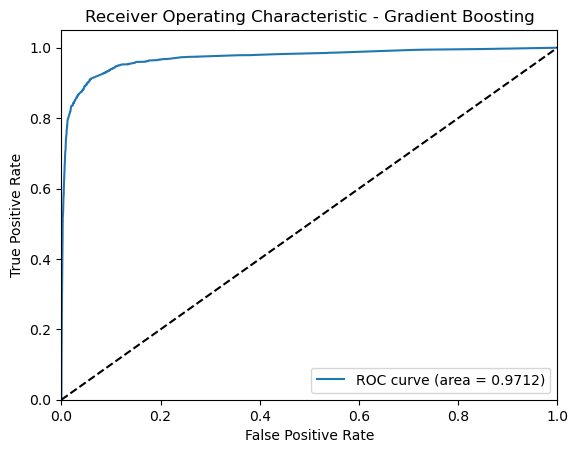


📌 Model: Support Vector Machine

  ✅ Trained in 1567.26 seconds.

  ✅ Support Vector Machine Evaluation Metrics:
    🔹 Accuracy: 0.9337
    🔹 Precision: 0.9439
    🔹 Recall: 0.3804
    🔹 F1 Score: 0.5423
    🔹 ROC AUC: 0.0000


📌 Model: Linear Support Vector Machine

  ✅ Trained in 17.80 seconds.

  ✅ Linear Support Vector Machine Evaluation Metrics:
    🔹 Accuracy: 0.9725
    🔹 Precision: 0.9002
    🔹 Recall: 0.8248
    🔹 F1 Score: 0.8609
    🔹 ROC AUC: 0.0000


📌 Model: Naive Bayes

  ✅ Trained in 0.03 seconds.

  ✅ Naive Bayes Evaluation Metrics:
    🔹 Accuracy: 0.9157
    🔹 Precision: 0.5714
    🔹 Recall: 0.7304
    🔹 F1 Score: 0.6412
    🔹 ROC AUC: 0.9213



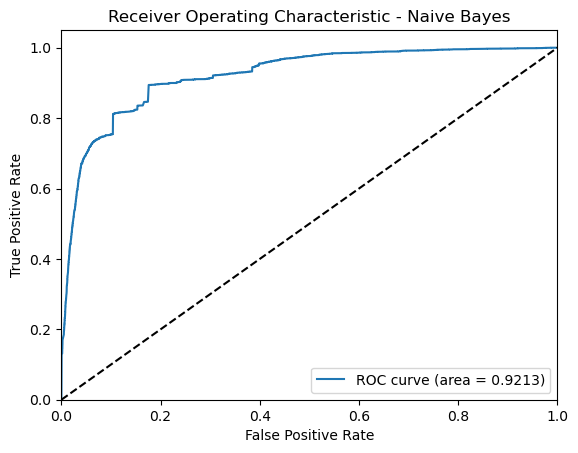


📌 Model: Artificial Neural Network

  ✅ Trained in 529.01 seconds.

  ✅ Artificial Neural Network Evaluation Metrics:
    🔹 Accuracy: 0.9797
    🔹 Precision: 0.9134
    🔹 Recall: 0.8873
    🔹 F1 Score: 0.9001
    🔹 ROC AUC: 0.9867



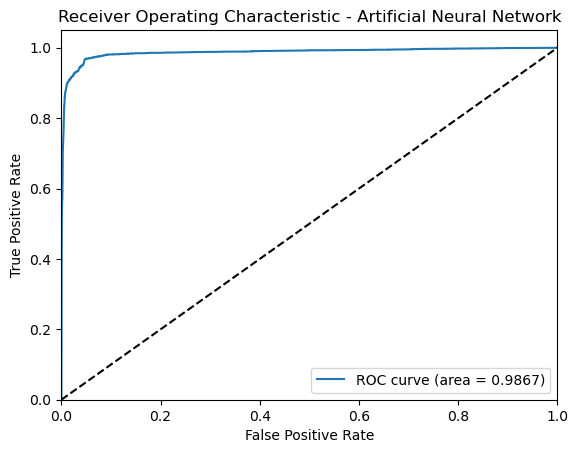

In [10]:
# Dictionary to hold models
models = {
    "Random Forest": random_forest(X_train, y_train),
    "Gradient Boosting": gradient_boosting(X_train, y_train),
    # "Support Vector Machine": support_vector_machine(X_train, y_train),  # this takes about 1500 sec.. 
    "Linear Support Vector Machine": linear_support_vector_machine(X_train, y_train),
    "Naive Bayes": naive_bayes(X_train, y_train),
    # "Artificial Neural Network": artificial_neural_network(X_train, y_train),  # this takes about 500 sec..
}

# Train and evaluate models
for name, model in models.items():
    trained_model = train_model(model, X_train, y_train, model_name=name)
    evaluate_model(trained_model, X_test, y_test, model_name=name)



# 2. **Verify which feature sets are most suitable for malware classification**

This involves identifying which data attributes (features) are most predictive of malware to enhance the classifier's performance.

## Feature Suitability for Malware Classification

- Use feature selection techniques like recursive feature elimination, feature importance from tree-based models, or L1 regularization to identify which features contribute most to the predictive power of the model.
- Conduct ablation studies where you systematically remove or add feature sets to see how performance is affected.
- Compare models trained on different subsets of features (e.g., API calls only, URL features only, combined features) to identify which sets or combinations are the most predictive.


# 3. **Explore how explanation methods can support the design and improvement of classification algorithms**

This points to the use of explanation methods, such as SHAP, to interpret ML models' decisions, possibly to increase their transparency and trustworthiness.

This project focuses on how existing explanation methods could support a better understanding of what the classifier is learning. A known problem in the literature is indeed "shortcut learning", i.e., learning information not related to actual maliciousness. For example, a network intrusion detection algorithm may be learning that "large volumes of outgoing bytes" are an attack, but this is clearly overfitting the task. Explanations methods to be explored include (see [2]): SHAP, LIME, LEMNA, LRP.


## Use of Explanation Methods to Support Model Design:

- Apply SHAP or LIME to your models to get explanations for individual predictions, which can provide insights into what features are driving the model’s decisions for each class.
- Use global feature importance derived from SHAP to understand overall model behavior and identify which features are generally most impactful across all predictions.
- Based on the insights from SHAP, iterate on your model design, potentially simplifying models by removing less important features or engineering new features to improve clarity and performance.
